In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
!conda install bokeh
from bokeh.palettes import Viridis5
from bokeh.plotting import figure, show
from bokeh.models.tools import HoverTool

Solving environment: done

# All requested packages already installed.



# Load Data

In [2]:
df = pd.read_csv("quotas.csv")
df.shape

(13417, 5)

In [3]:
df.tail()

,date,quota_value,net_worth,fund_name,fund_class
13412,9/8/2020,346.020993,7.535706e+08,Fundo 195,Fundo de Ações
13413,9/11/2020,203.617646,4.684407e+07,Fundo 193,Fundo Multimercado
13414,9/10/2020,203.594144,4.683867e+07,Fundo 193,Fundo Multimercado
13415,9/9/2020,203.549545,4.682841e+07,Fundo 193,Fundo Multimercado
13416,9/8/2020,203.520108,4.682163e+07,Fundo 193,Fundo Multimercado


In [4]:
df.describe()

,quota_value,net_worth
count,13417.000000,1.341700e+04
mean,108.166037,8.547900e+08
std,652.900078,2.051042e+09
min,0.000000,0.000000e+00
25%,1.202283,5.079743e+07
50%,2.185081,2.001676e+08
75%,11.550156,7.659775e+08
max,12757.229860,2.075817e+10


## Check for missing data

In [5]:
np.count_nonzero(df.isna())

0

## Convert date string to datetime object

In [6]:
df["date"] = df["date"].apply(lambda x: datetime.strptime(x,'%m/%d/%Y'))

## Sort values according to time, remove weekends, get funds with 22 values total

In [7]:
# Dayofweek retorna 5 ou 6 se for sabado ou domingo respectivamente
# Desconsidera o dia 07/09 que foi feriado
# Seleciona apenas os que possuem valores nos 22 dias
clean_df = df.dropna().sort_values(by=["date"])
clean_df = clean_df.where(clean_df["date"].dt.dayofweek < 5).dropna()
clean_df.drop(list(clean_df[clean_df["date"] == datetime.fromisoformat("2020-09-07")].index),inplace=True)
funds = clean_df.groupby(["fund_name"])
for name,fund in funds:
    if fund.shape[0] < 22:
        clean_df.drop(list(fund.index),inplace = True)

In [8]:
def getRetornoDiario(quota_values):
    retorno_diario = quota_values/quota_values.shift(1) -1
    return retorno_diario
        

In [9]:
def getRetornoAcumulado(valor_cota_atual,valor_cota_inicial):
    return ((valor_cota_atual)/valor_cota_inicial -1)

In [10]:
def getSharpe(fund,taxa_livre_risco):
    sharpe = []
    for i in range(len(fund["acumulado"])):
        """if i == 0:
            sharpe.append(0)
        else:"""
        retorno_anualizado = (1 + fund["acumulado"].iloc[i])**(252/(i+1)) - 1
        volatility = np.sqrt(252)*fund["diario"].iloc[:i].std()
        sharpe.append((retorno_anualizado - taxa_livre_risco)/volatility)
    return sharpe

In [11]:
clean_df["diario"] = clean_df.groupby(["fund_name"])["quota_value"].transform(getRetornoDiario)

# Retorno Acumulado

## Split data into funds - Transform - Regroup data

In [12]:
clean_df["date"].max()

Timestamp('2020-09-30 00:00:00')

In [13]:
# x é o valor de cota de um determinado fundo numa determinada data, 
# e como os dados estão ordenados pela data, x.iloc[0] fornece o valor inicial da cota do fundo
clean_df["acumulado"] = clean_df.groupby(["fund_name"])["quota_value"].transform(lambda x: getRetornoAcumulado(x,
                                                                         x.iloc[0]))

In [14]:
# Seleciona os valores finais de retorno acumulado com base na ultima na ultima data, que é 30/09. 
# Em seguida ordena os valores em ordem crescente
acumulado_ranking = clean_df.where(clean_df["date"] == clean_df["date"].max()).sort_values(by=["acumulado"])
acumulado_ranking.dropna(inplace=True)

In [15]:
# pega os ultimos elementos da ordenação
top5_acumulado = acumulado_ranking.tail(5)

In [16]:
top5_acumulado

,date,quota_value,net_worth,fund_name,fund_class,diario,acumulado
8380,2020-09-30,2.036821,1.753955e+07,Fundo 224,Fundo de Ações,0.010687,0.034403
8841,2020-09-30,1.984240,8.096399e+07,Fundo 201,Fundo Multimercado,0.002932,0.035986
9808,2020-09-30,1.260221,1.319985e+08,Fundo 128,Fundo Multimercado,0.011414,0.037637
8649,2020-09-30,3.172279,7.626037e+07,Fundo 585,Fundo Multimercado,-0.023713,0.099325
10138,2020-09-30,2.495152,5.066173e+07,Fundo 67,Fundo Multimercado,0.000659,0.255209


## Plot com matplotlib

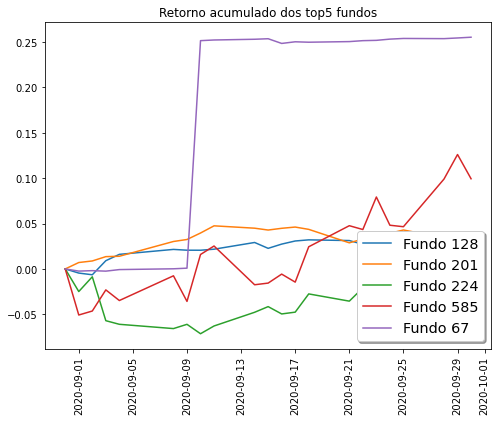

In [17]:
# Separa os dados de acordo com o fundo, e caso ele esteja no top5, 
# a série temporal de retorno acumulado é retornada
funds = clean_df[clean_df["fund_name"].isin(top5_acumulado["fund_name"])].groupby(["fund_name"])
fig, ax = plt.subplots()
fig.set_size_inches((8,6))
for name, group in funds:
    ax.plot(group["date"],group["acumulado"],label=name)
legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
plt.xticks(rotation=90)
plt.title("Retorno acumulado dos top5 fundos")
plt.show()

## Plot com bokeh

In [33]:
funds = clean_df.where(clean_df["fund_name"].isin(top5_acumulado["fund_name"])).groupby(["fund_name"])
names = []
groups = []
for fund in funds:
    names.append(fund[0])
    groups.append(fund[1])

In [34]:
p = figure(plot_width=800, plot_height=250, x_axis_type="datetime")
p.title.text = 'Retorno acumulado dos top5 fundos'
for name,group,color in zip(names,groups,Viridis5):
    p.line(group["date"], group["acumulado"], line_width=2, color=color, alpha=0.8,legend_label=name)
p.legend.location = "top_left"
p.legend.click_policy="hide"
p.add_tools(HoverTool(
    tooltips=[('date', '@x{%F}'),('acumulado','@y')],
          formatters={'@x': 'datetime'},
    mode='vline'
))
show(p)

# Sharpe

## Split data into funds - Transform - Regroup data

In [20]:
clean_df["sharpe"] = np.zeros(clean_df.shape[0])
funds = clean_df.groupby(["fund_name"])
for name,fund in funds:
    shapes = getSharpe(fund,0.0185)
    indexes = fund.index
    for i in range(fund.shape[0]):
        clean_df["sharpe"].loc[indexes[i]] = shapes[i]

/home/usuario/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-10-242b99253356>:9: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe.append((retorno_anualizado - taxa_livre_risco)/volatility)


In [21]:
# Checa quais os indices de sharpe para a data inicial eram diferentes de infinito
clean_df["sharpe"].where(clean_df["date"] == clean_df["date"].min()).dropna()

Series([], Name: sharpe, dtype: float64)

In [22]:
#Checa quais fundos que tiveram o retorno acumulado igual tanto na data 01/09 quanto em 31/08
funds = clean_df.groupby(["fund_name"])
for name, group in funds:
    if (group["acumulado"].iloc[0] == group["acumulado"].iloc[1]):
        print(name)

Fundo 115
Fundo 505
Fundo 577


# Os fundos listados acima possuem sharpe = +/- inf, e serão descartados da análise final

In [23]:
f115 = clean_df.where(clean_df["fund_name"] == "Fundo 115").dropna()
retorno_anualizado = (1 + f115["acumulado"].iloc[-1])**(252/(22)) - 1
s = (retorno_anualizado - 0.0185)/(np.sqrt(252) * f115["diario"][:-1].std())
print("Sharpe Ratio para o fundo 115 é: ",s)

Sharpe Ratio para o fundo 115 é:  inf


<ipython-input-23-348363a7c9f9>:3: RuntimeWarning: divide by zero encountered in double_scalars
  s = (retorno_anualizado - 0.0185)/(np.sqrt(252) * f115["diario"][:-1].std())


## Computa o ranking pelo Sharpe Ratio

In [24]:
# Idem do caso anterior, mas para o sharpe
sharpe_ranking = clean_df.where(clean_df["date"] == clean_df["date"].max()).sort_values(by=["sharpe"])
sharpe_ranking.replace([np.inf, -np.inf], np.nan,inplace=True)
sharpe_ranking.dropna(inplace=True)
top5_sharpe = sharpe_ranking.tail(5)
top5_sharpe

,date,quota_value,net_worth,fund_name,fund_class,diario,acumulado,sharpe
12917,2020-09-30,178.620651,1.363698e+08,Fundo 162,Fundo Multimercado,0.000136,0.003197,48.217339
9694,2020-09-30,1.062862,7.537954e+06,Fundo 352,Fundo Multimercado,0.000196,0.003798,55.029733
12908,2020-09-30,1.513171,3.344207e+08,Fundo 159,Fundo Multimercado,0.000156,0.003449,65.189102
12594,2020-09-30,1.194438,3.010803e+07,Fundo 53,Fundo Multimercado,0.000184,0.004479,138.017758
10305,2020-09-30,1.256792,4.589653e+08,Fundo 107,Fundo Multimercado,0.000362,0.007704,194.017700


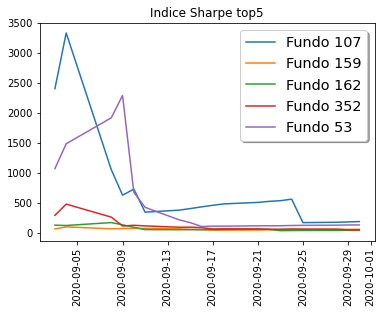

In [25]:
funds = clean_df[clean_df["fund_name"].isin(top5_sharpe["fund_name"])].groupby(["fund_name"])
fig, ax = plt.subplots()
for name, group in funds:
    ax.plot(group["date"],group["sharpe"],label=name)
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.title("Indice Sharpe top5")
plt.xticks(rotation=90)
plt.show()

## Plot com bokeh

In [26]:
funds = clean_df.where(clean_df["fund_name"].isin(top5_acumulado["fund_name"])).groupby(["fund_name"])
names = []
groups = []
for fund in funds:
    names.append(fund[0])
    groups.append(fund[1])

In [32]:
p = figure(plot_width=800, plot_height=250, x_axis_type="datetime")
p.title.text = 'Sharpe Ratio dos top5 fundos'
for name,group,color in zip(names,groups,Viridis5):
    p.line(group["date"], group["sharpe"], line_width=2, color=color, alpha=0.8,legend_label=name)
p.legend.location = "top_left"
p.legend.click_policy="hide"
p.add_tools(HoverTool(
    tooltips=[('date', '@x{%F}'),('Sharpe Ratio','@y')],
          formatters={'@x': 'datetime'},
    mode='vline'
))
show(p)

# Correlação

In [41]:
# Cria um dataframe onde o nome das colunas são os nomes dos fundos 
# e os valores são seus respectivos retornos acumulados
funds = clean_df.groupby(["fund_name"])
correlation_funds = {}
for name, group in funds:
    correlation_funds[name] = list(group["diario"])
corr_df = pd.DataFrame.from_dict(correlation_funds)

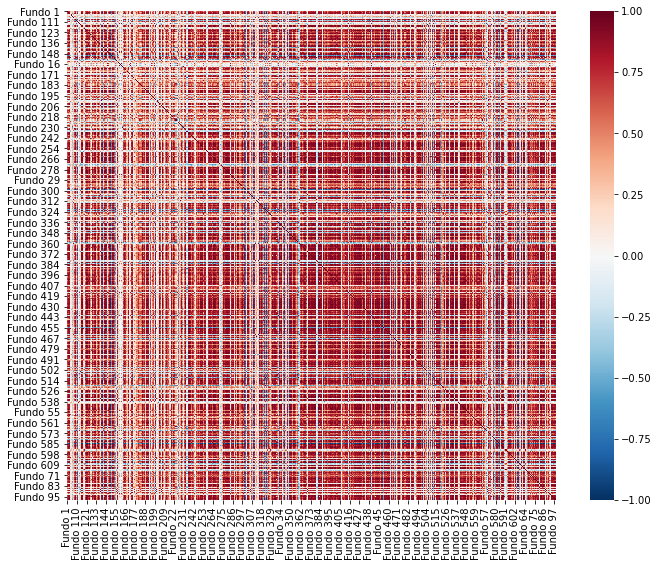

In [42]:
corrmat = corr_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat,cmap=sns.color_palette("RdBu_r", 1000), vmin=-1,vmax=1, square=True);

In [43]:
# Como a matriz de correlação entre os fundos é simétrica em torno da diagonal principal,
# vamos selecionar apenas a matriz triangular superior (poderia ser a inferior também)
# np.triu retorna True caso o valor da matriz esteja acima da diagonal principal 
mask_ut=np.triu(np.ones(corrmat.shape),k=1).astype(np.bool)

In [44]:
correlations = corrmat.where(mask_ut).fillna(0).unstack().sort_values()
correlations.tail()

Fundo 512  Fundo 248    0.999997
Fundo 262  Fundo 158    0.999999
Fundo 82   Fundo 375    1.000000
Fundo 405  Fundo 318    1.000000
Fundo 577  Fundo 505    1.000000
dtype: float64